# Reverse time migration example on a 2D  acoustic model

## PDE 

The acoustic wave equation for the square slowness m and a source q is given in 3D by :

\begin{cases} 
 &m \frac{d^2 u(x,t)}{dt^2} - \nabla^2 u(x,t) =q  \\
 &u(.,0) = 0 \\
 &\frac{d u(x,t)}{dt}|_{t=0} = 0 
\end{cases}

with the zero initial conditons to guaranty unicity of the solution

### Solve forward in time 

The wave equation with absorbing boundary conditions writes

\begin{equation}
 \eta \frac{d u(x,t)}{dt} + \frac{d^2 u(x,t)}{dt^2} - \nabla^2 u(x,t) =q
\end{equation}

and the adjont wave equation 

\begin{equation}
-\eta \frac{d u(x,t)}{dt} + \frac{d^2 u(x,t)}{dt^2} - \nabla^2 u(x,t) =q 
\end{equation}

where $ \eta$  is a damping factor for the absorbing boundary conditions equal to zero inside the physical domain and decreasing inside the absorbing layer from the pysical domain to the border.

##  Devito implementation
This two equations are trivial to implement and solve with devito as it only requires to write 

```
    wave_equation_forward = m*u.dt2 - u.laplace + damp * u.dt
    stencil_forward = solve(wave_equation,u,forward)[0]

    wave_equation_adjoint= m*u.dt2 - u.laplace - damp * u.dt
    stencil_adjoint = solve(wave_equation,u.backward)[0]
```

and can be seen in the examples folder of devito


## Set up generic Python environment.

In [1]:
# Add module path
import sys
import os

currloc = os.getcwd()

sys.path.append(currloc+'/../../devito/')
sys.path.append(currloc+'/../../examples/')
sys.path.append(currloc+'/../acoustic/')

# Add plotting, numpy, scipy
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

from scipy import ndimage
import numpy as np

# Setup figure size
fig_size = [0, 0]
fig_size[0] = 18
fig_size[1] = 13
plt.rcParams["figure.figsize"] = fig_size

/Volumes/Users/mloubout/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Import OPESCI components.

In [2]:
from examples.containers import IShot, IGrid
from examples.acoustic.Acoustic_codegen import Acoustic_cg
from devito import clear_cache
from devito.memmap_manager import MemmapManager

# Setup number of threads, affinity and architecture
os.environ["DEVITO_ARCH"] = "gnu"
os.environ["DEVITO_OPENMP"] = "1"
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["KMP_AFFINITY"] = "explicit,proclist=[0,1,2,3]"

## Dimensions on constant initialization.

In [4]:
# Define geometry
dimensions = (1601, 401)  # Number of grid point in the velocity model file
origin = (0., 0.)  # Origin of the model in m
spacing = (7.5, 7.5)  # Grid size in m
spc_order = 8  # Spacial discretization order

x_axis = [7.5*x for x in range(0, 1601)]
z_axis = [7.5*z for z in range(0, 401)]

## Load synthetic velocity model.

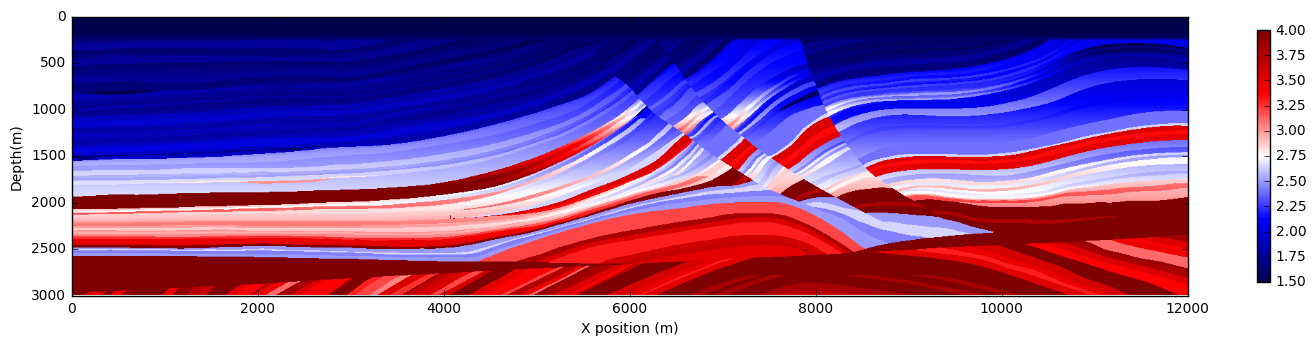

In [5]:
# Read velocity
vp = np.fromfile(currloc+'/../data/Simple2D/vp_marmousi_bi', dtype='float32', sep="")
# Reshape the velocity model
vp = vp.reshape(dimensions)


# Create exact model
model = IGrid()
model.create_model(origin, spacing, vp)
# Plot true velocity
fig1 = plt.figure()
l = plt.imshow(np.transpose(vp), vmin=1.5, vmax=4, cmap=cm.seismic, extent=[np.min(x_axis), np.max(x_axis), np.max(z_axis), np.min(z_axis)])
plt.xlabel('X position (m)')
plt.ylabel('Depth(m)')
plt.axis('scaled')
plt.colorbar(l, shrink=.25)
plt.show()

## Create "initial guess" by smoothening the synthetic velocity model.

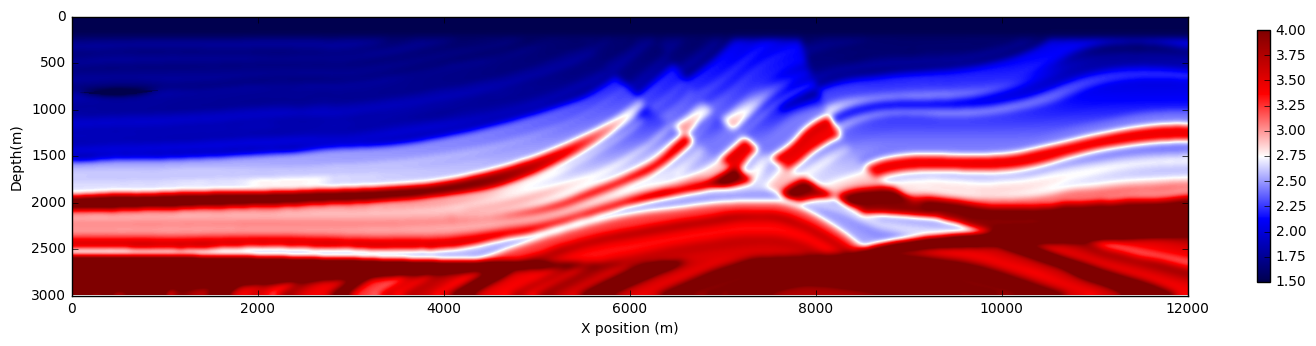

In [6]:
# Smooth velocity
smooth_vp = ndimage.gaussian_filter(vp, sigma=(5,5), order=0)

# Inforce the minimum and maximum velocity to be the same as the true model to insure both mdelling solver will use the same value for the time step dt
smooth_vp = np.max(vp)/np.max(smooth_vp)* smooth_vp
truc = (vp <= (np.min(vp)+.01))
smooth_vp[truc] = vp[truc]

# Create the smooth background model
model0 = IGrid()
model0.create_model(origin, spacing, smooth_vp)

# Plot smooth velocity
fig2 = plt.figure()
l = plt.imshow(np.transpose(smooth_vp), vmin=1.5, vmax=4, cmap=cm.seismic, extent=[np.min(x_axis), np.max(x_axis), np.max(z_axis), np.min(z_axis)])
plt.xlabel('X position (m)')
plt.ylabel('Depth(m)')
plt.axis('scaled')
plt.colorbar(l, shrink=.25)
plt.show()

## Acquisition geometry (i.e. set up sources and receivers)

In [7]:
# Source function: Set up the source as Ricker wavelet for f0
def source(t, f0):
    r = (np.pi * f0 * (t - 1./f0))

    return (1-2.*r**2)*np.exp(-r**2)

# Define seismic data.
data = IShot()

f0 = .030  # 15Hz peak frequency
dt = model.get_critical_dt()  # Time stepping rate as the overall sampling rate
t0 = 0.0  # Origin time (in ms)
tn = 4000  # Final time (in ms)
nt = int(1+(tn-t0)/dt)  # Number of time steps
print(dt,nt)
t_axis = [1e-3*dt*t for t in range(0, nt)]
time_series = source(np.linspace(t0, tn, nt), f0)  # Generate the source time signature

# Receiver coordinates. The receivers are located at the ocean bottom (200 grid points) and at every grid point along the x axis
receiver_coords = np.zeros((1601, 2))
receiver_coords[:, 0] = np.linspace(origin[0],
                                    origin[0] + dimensions[0] * spacing[0],
                                    num=1601)
receiver_coords[:, 1] = origin[1] + 200 * spacing[1]
data.set_receiver_pos(receiver_coords)
data.set_shape(nt, 1601)

(0.67021279315594584, 5969)


## Example of a shot record

In [10]:
# Define the source location
location = (origin[0] + dimensions[0] * spacing[0] * 0.5,
            origin[1] + 2 * spacing[1])
data.set_source(time_series, dt, location)

# Create acoustic modelling kernel.
Acoustic = Acoustic_cg(model, data, t_order=2, s_order=10)

# Execute acoustic forward model
rec, u, gflopss, oi, timings = Acoustic.Forward(save=False, cse=True)

GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6a9b09674bffbebff7b95a3e39c083b023c60607.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9d37173ff9f97243dfc8efafa0d0795291f11e12.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/d7e3ca09f9b730d8bd8d69b5e40f5328b19e04fb.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/948bde7d1003e0755b471adde51cf4b9745bad1a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9d94e0e6b9ea47bf089d1513f4dbcc323e026567.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a26fe39e4d65b72b0edbfa5d5db9f2046c2f1994.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/ed2d255403e15ecb656d1252d14dcbbc222368fc.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/4c052f6d5a618c332fcccce9fcebd6d8224292a2.cpp


Shape: (1681 x 481) - Cache Blocking: None


Time: 21.620035 s (217 MCells/s)


Stencil: 3.437500 OI, 12.58 GFlops/s (time: 21.095518 s)


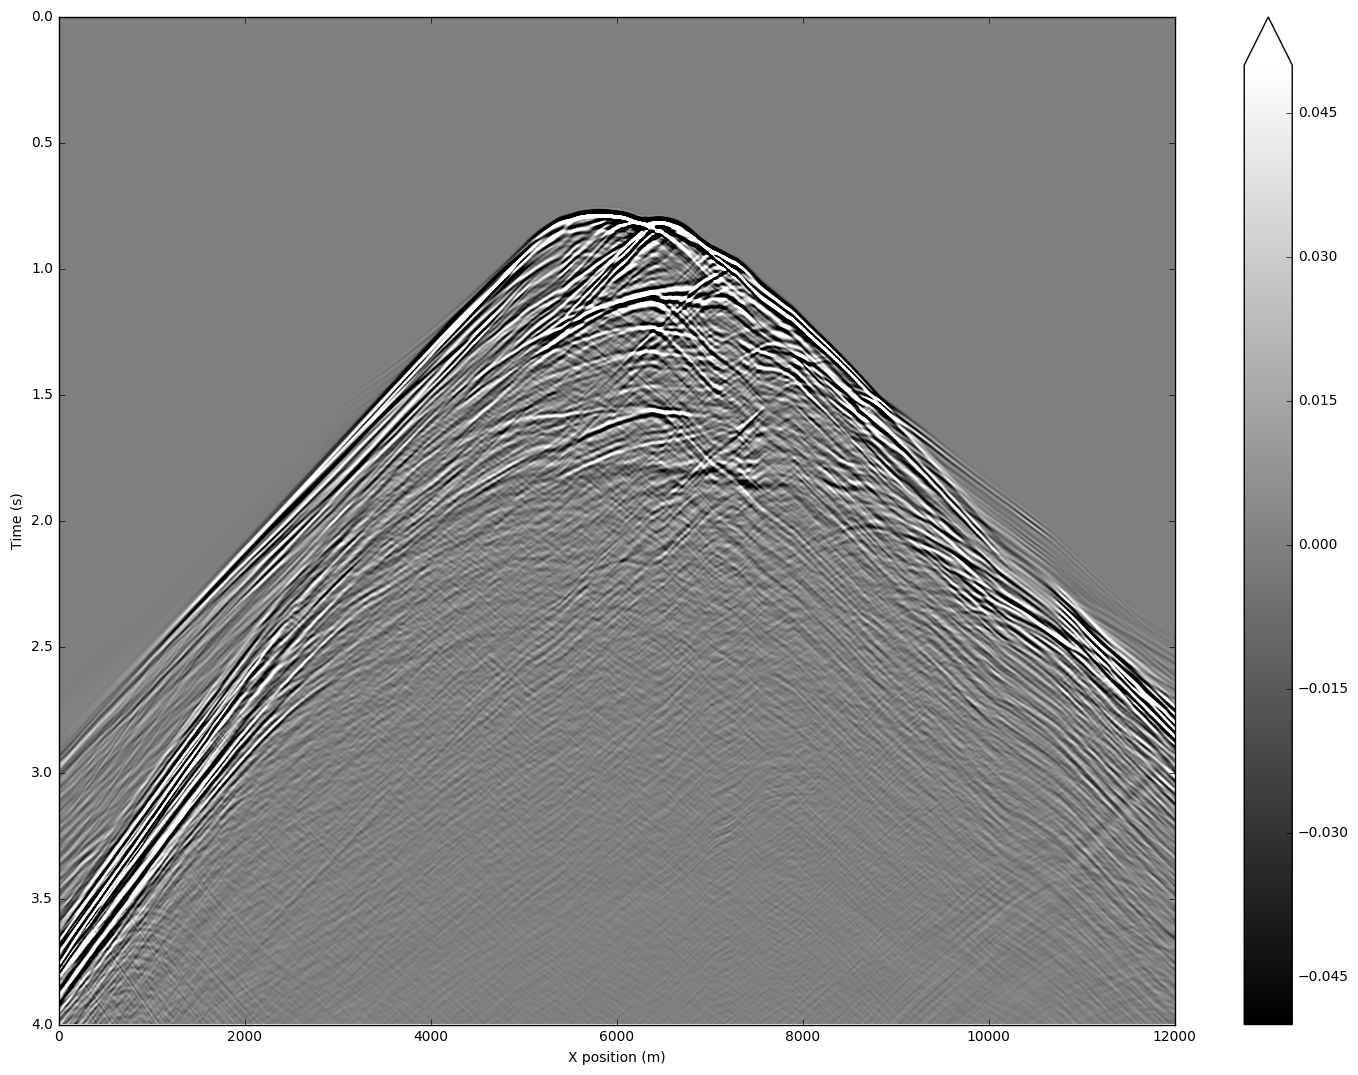

In [11]:
# Show the shot record at the receivers
fig3 = plt.figure()
l = plt.imshow(rec, vmin=-.05, vmax=0.05, cmap=cm.gray, extent=[np.min(x_axis), np.max(x_axis), np.max(t_axis), np.min(t_axis)])
plt.xlabel('X position (m)')
plt.ylabel('Time (s)')
plt.axis('auto')
plt.colorbar(extend='max')
plt.show()

# RTM

## Least square objective Imaging condition

We will consider here the least square objective. We can writte the data fitting problem known as FWI or RTM as a leqast square problem as follows:

\begin{equation}
min_m \Phi(m) := \frac{1}{2} \| P_r A^{-1}(m) q - d\|_2^2
\end{equation}


where $m = \frac{1}{c^2}$ is the square slowness, $A^{-1}(m)$ is the time stepping operator (inverse of the discretized wave equation), $P_r $ is the measurement operator ,  $q$ is the source and $d$ is the obeserved data.

For multiple sources it becomes a simple sum over experiments as a separable problem :


\begin{equation}
 min_m \Phi(m) := \sum_{s=1}^{n_{src}} (\frac{1}{2} \| P_{r_s} A^{-1}(m) q_s - d_s\|_2^2)
\end{equation}


We can then obtain the gradient with respect to the square slowness as

\begin{equation}
\nabla_m \Phi(m) = \sum_{s=1}^{n_{src}} ( - (\frac{dA(m)u_s}{dm})^T v_s ) = \sum_{s=1}^{n_{src}} ( \nabla_m \Phi(m)_s )
\end{equation}

where $v_s$ is the soltuion if the adjoint wave equation $A^{T}(m)  v = P_{r_s}^T (P_{r_s} u_s - d_s)$ and $ u_s$ is the forward wavefield solution of $A(m)u_S = q_s$. For the simple acoustic case the  gradient can be rewritten as 
\begin{equation}
\nabla_m \Phi(m)_s = - \sum_{t=1}^{nt} \frac{d^2u_s(t)}{dt^2} .v_s(t)
\end{equation}


This last equation is the imaging condtion. Using it in an iterative method (gradient decent, Quasi-Newton,..) corresponds to FWI where the aim is to invert for the velocity model from an "not so good" inital guess. Once a good estimate of the background velocity model is obtained, this imaging condition is used to obtain an image of the subsurface known as RTM image. In te follwing we compute the RTM image on the marmousi model from an artificial background velocity model.

In [12]:
MemmapManager.set_memmap(True)
# Number of sources
nsrc = 101
# Sources locations
sources = np.linspace(spacing[0], origin[0] + dimensions[0] * spacing[0], num=nsrc)
# Initialize the image at zero
grad = np.zeros(dimensions)
# Extend it to match the gradient dimensions with the absorbing boundary layer
grad = np.pad(grad, [(40, 40),(40,40)],'edge')

# Looping over the sources
for i in range(0,nsrc):
    print("Starting source : " + str(i+1) + " of " + str(nsrc))
    # Set current source location
    location = (sources[i] ,origin[1] + 2 * spacing[1])
    data.set_source(time_series, dt, location)
    # Generate the true data (loaded from file in a real case)
    Acoustic = Acoustic_cg(model, data, t_order=2, s_order=4)
    rec, u, gflopss, oi, timings = Acoustic.Forward(save=False, cse=True)
    # Generate the data and wavefield for the smooth background model
    Acoustic0 = Acoustic_cg(model0, data, t_order=2, s_order=4)
    rec0, u0, gflopss, oi, timings = Acoustic0.Forward(save=True, cse=True)
    # Compute the gradient from the data difference and the smooth wavefield and accumulate it in the final image
    grad =  grad + Acoustic0.Gradient(rec0 - rec, u0, cache_blocking=None)

GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/29b71b0d72e26f2467f5cdfeee247a6e3d740fef.cpp


Starting source : 1 of 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/0f2e2d89fa8084c66debec66f62319684df29e1a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9d593808ed339dbf9048e56d6c63c46d083a1c21.cpp


Shape: (1681 x 481) - Cache Blocking: None


Time: 14.316165 s (333 MCells/s)


Stencil: 1.937500 OI, 11.35 GFlops/s (time: 13.180875 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/dce2e6a30dbdbbe31b50d6d4f2f0ae126f295806.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a2aa859d8cc1e3005645e4461ec3551b4a1c5d45.cpp


IOError: [Errno 28] No space left on device

In [ ]:
# RTM result
fig4 = plt.figure()
l = plt.pcolor(x_axis, z_axis, np.transpose(grad), vmin=-1e3, vmax=1e3, cmap=cm.gray)
plt.xlabel('X position (m)')
plt.ylabel('Depth(m)')
plt.gca().invert_yaxis()
plt.colorbar()
plt.axis('scaled')
plt.show()

In [ ]:
# True Shot record
fig5 = plt.figure()
l = plt.pcolor(x_axis, t_axis, rec, vmin=1.5, vmax=4, cmap=cm.gray)
plt.xlabel('X position (m)')
plt.ylabel('Time (s)')
plt.gca().invert_yaxis()
plt.colorbar()
plt.axis('scaled')
plt.show()

In [ ]:
# Smooth velocity Shot record
fig6 = plt.figure()
l = plt.pcolor(x_axis, t_axis, rec0, vmin=1.5, vmax=4, cmap=cm.gray)
plt.xlabel('X position (m)')
plt.ylabel('Time (s)')
plt.gca().invert_yaxis()
plt.colorbar()
plt.axis('scaled')
plt.show()

In [ ]:
# Data difference (adjoint source for the gradient)
fig7 = plt.figure()
l = plt.pcolor(x_axis, t_axis, rec0 - rec, vmin=1.5, vmax=4, cmap=cm.gray)
plt.xlabel('X position (m)')
plt.ylabel('Time (s)')
plt.gca().invert_yaxis()
plt.colorbar()
plt.axis('scaled')
plt.show()